In [63]:
import os
from sys import path
path.append("../../")
cwd = os.getcwd()

In [64]:
os.chdir("../code")
# Utils
# =====
from Modules.Utils.dt8122_snippets import *
#from Modules.Utils.helpers import *
from Modules.Utils.dataClass_helpers import *
from Modules.Utils.DataLoader import *
from Modules.Utils.dataPlot_helpers import *
from Modules.Utils.miscellaneous_helpers import *

from Modules.Models.ModelWrapper import *
from Modules.Models.Unet import *

# Models
# =====
# ----------------------------
# 0) Device
# ----------------------------
device = (
     torch.device("mps") if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()
     else torch.device("cuda") if torch.cuda.is_available()
     else torch.device("cpu")
 )
#device = torch.device("cpu")  # Force CPU for compatibility
print("Using device:", device)

CASE1 = 1
cropBool1 = False  # Whether to use the crop source distribution
shufflePairings1 = False  # Whether to shuffle pairings in the dataset

CASE2 = 2
cropBool2 = True  # Whether to use the crop source distribution
shufflePairings2 = True  # Whether to shuffle pairings in the dataset

CASE3 = 3
cropBool3 = True  # Whether to use the crop source distribution
shufflePairings3 = False  # Whether to shuffle pairings in the dataset


Using device: mps


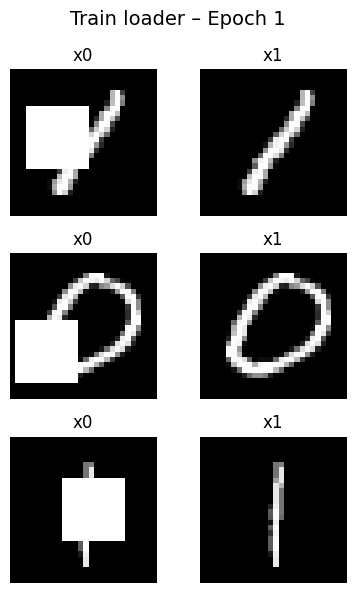

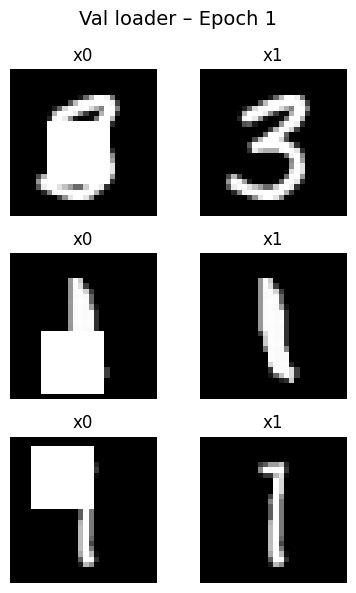

In [65]:
import matplotlib.pyplot as plt

def plot_msint_pairs_over_epochs(loader, val_loader=None, epochs=1, n_pairs=3, shuffle=False):
    """
    Plot the first n_pairs (x0, x1) pairs from loader and val_loader
    across several epochs to visualize reshuffling.
    """

    # epoch = 1
    # if shuffle:
    #     print("Shuffling pairings in the dataset (pre-training)")
    #     loader.shuffle_pairings(seed=0, epoch=epoch)
    #     print(loader.order0)

    #     if val_loader is not None:
    #         val_loader.shuffle_pairings(seed=0, epoch=epoch)

    for epoch in range(epochs):
        # Shuffle if supported (your CachedLoader has shuffle())
        if hasattr(loader, "shuffle"):
            loader.shuffle(seed=0, epoch=epoch)
        if val_loader is not None and hasattr(val_loader, "shuffle"):
            val_loader.shuffle(seed=0, epoch=epoch)

        # Extract first n_pairs from train loader
        x0s, x1s = [], []
        for i, (x0, x1) in enumerate(loader):
            x0s.append(x0[0].cpu())
            x1s.append(x1[0].cpu())
            if i >= n_pairs - 1:
                break

        # Plot train loader pairs
        fig, axes = plt.subplots(n_pairs, 2, figsize=(4, 2*n_pairs))
        fig.suptitle(f"Train loader – Epoch {epoch+1}", fontsize=14)
        for i in range(n_pairs):
            axes[i, 0].imshow(x0s[i].squeeze(), cmap="gray")
            axes[i, 0].set_title("x0")
            axes[i, 0].axis("off")
            axes[i, 1].imshow(x1s[i].squeeze(), cmap="gray")
            axes[i, 1].set_title("x1")
            axes[i, 1].axis("off")
        plt.tight_layout()
        plt.show()

        # Do the same for val loader if provided
        if val_loader is not None:
            x0s, x1s = [], []
            for i, (x0, x1) in enumerate(val_loader):
                x0s.append(x0[0].cpu())
                x1s.append(x1[0].cpu())
                if i >= n_pairs - 1:
                    break

            fig, axes = plt.subplots(n_pairs, 2, figsize=(4, 2*n_pairs))
            fig.suptitle(f"Val loader – Epoch {epoch+1}", fontsize=14)
            for i in range(n_pairs):
                axes[i, 0].imshow(x0s[i].squeeze(), cmap="gray")
                axes[i, 0].set_title("x0")
                axes[i, 0].axis("off")
                axes[i, 1].imshow(x1s[i].squeeze(), cmap="gray")
                axes[i, 1].set_title("x1")
                axes[i, 1].axis("off")
            plt.tight_layout()
            plt.show()


plot_msint_pairs_over_epochs(train_loader3,
                              val_loader=val_loader3,
                                epochs=1, n_pairs=3, 
                                shuffle=True)

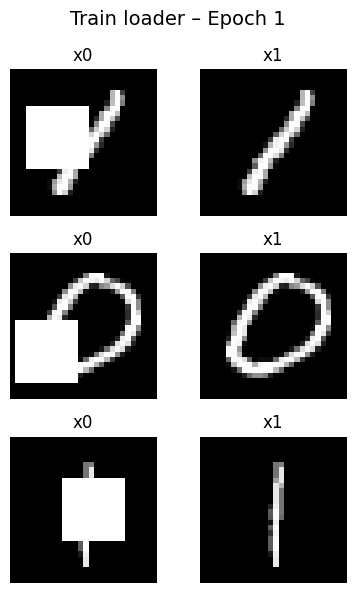

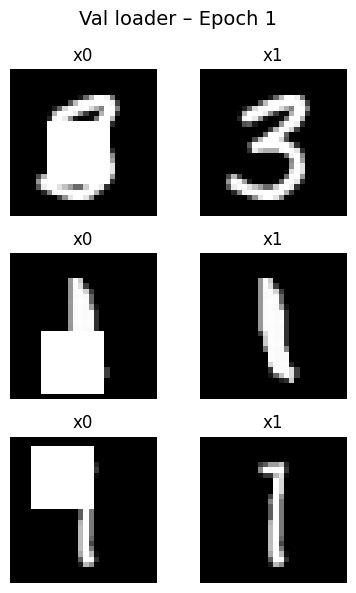

In [66]:
plot_msint_pairs_over_epochs(train_loader3, val_loader=val_loader3, epochs=1, n_pairs=3)

## Generate training and validation data

### Select data params 

In [67]:
# USER INPUT

# =============================== data ===============================
valFrac = 0.10              # Fraction of data to use for validation
seed = 42                   # Random seed for reproducibility
batchSize = 32              # Batch size for training
valBool = 1                 # Whether to use a validation set
splitSeed = 42              # Seed for data splitting
initialShuffleSeed = 12345  # Seed for initial shuffling

# =============================== model ===============================
Tfeats = 11                   # Number of time-feature channels (see `Unet.py`)
modelType = "UNet"            # Currently only "UNet" implemented
lr = 1e-4                     # Adam learning rate
saveThreshold = 0.99          # Save model if loss reduces by this factor
ES = 10                        # Early stopping patience
device = "mps"
model_num  = 1

# Model loading
# ============
load_best = 1
ES_check = [10]
epoch_check = range(100)

In [68]:
# Load data objects (for plotting only)

data_params1 = {
    "shufflePairings": shufflePairings1,
    "cropBool":        cropBool1,
    "valFrac":         valFrac,
    "splitSeed":        splitSeed,
    "initialShuffleSeed": initialShuffleSeed,
    "batchSize":       batchSize,
    "valBool":         valBool,
}

data_params2 = {
    "shufflePairings": shufflePairings2,
    "cropBool":        cropBool2,
    "valFrac":         valFrac,
    "splitSeed":        splitSeed,
    "initialShuffleSeed": initialShuffleSeed,
    "batchSize":       batchSize,
    "valBool":         valBool,
}

data_params3 = {
    "shufflePairings": shufflePairings3,
    "cropBool":        cropBool3,
    "valFrac":         valFrac,
    "splitSeed":        splitSeed,
    "initialShuffleSeed": initialShuffleSeed,
    "batchSize":       batchSize,
    "valBool":         valBool,
}


save_dir = path_constructor(data_params1, "data_processed")
os.makedirs(save_dir, exist_ok=True)
train_loader1 = torch.load(os.path.join(save_dir, "train_loader.pt"))
val_loader1 = torch.load(os.path.join(save_dir, "val_loader.pt"))
test_loader1 = torch.load(os.path.join(save_dir, "test_loader.pt"))


save_dir = path_constructor(data_params2, "data_processed")
os.makedirs(save_dir, exist_ok=True)
train_loader2 = torch.load(os.path.join(save_dir, "train_loader.pt"))
val_loader2 = torch.load(os.path.join(save_dir, "val_loader.pt"))
test_loader2 = torch.load(os.path.join(save_dir, "test_loader.pt"))


save_dir = path_constructor(data_params3, "data_processed")
os.makedirs(save_dir, exist_ok=True)
train_loader3 = torch.load(os.path.join(save_dir, "train_loader.pt"))
val_loader3 = torch.load(os.path.join(save_dir, "val_loader.pt"))
test_loader3 = torch.load(os.path.join(save_dir, "test_loader.pt"))




/var/folders/dn/jj6zl9nx6s541bq88x9x4zvm0000gn/T/ipykernel_78764/2606898284.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_loader1 = torch.load(os.path.join(save

In [69]:
# Load trained models
model_params = {
    "modelType":     modelType,
    "Tfeats":        Tfeats,         # Number of features in the vector field
    "ES":            ES,             # Early stopping patience for training
    "lr":            lr,             # Learning rate for the optimizer
    "saveThreshold": saveThreshold,  # Threshold for saving the model
    "device":        device          # Device to use for training
}

params1 = {**data_params1, **model_params}
path_intro1 = path_constructor(params1)
save_best_path1 = os.path.join(path_intro1, f"modelNum_{model_num}")
#os.makedirs(save_best_path, exist_ok=True)
trainer_path = os.path.join(save_best_path1, "trainer.pt")
trainer1 = torch.load(trainer_path)

params2 = {**data_params2, **model_params}
path_intro2 = path_constructor(params2)
save_best_path2 = os.path.join(path_intro2, f"modelNum_{model_num}")
#os.makedirs(save_best_path, exist_ok=True)
trainer_path = os.path.join(save_best_path2, "trainer.pt")
trainer2 = torch.load(trainer_path)

params3 = {**data_params3, **model_params}
path_intro3 = path_constructor(params3)
save_best_path3 = os.path.join(path_intro3, f"modelNum_{model_num}")
#os.makedirs(save_best_path, exist_ok=True)
trainer_path = os.path.join(save_best_path3, "trainer.pt")
trainer3 = torch.load(trainer_path)

# load best models
loaded1, load_path1 = load_best_checkpoint(
    load_best=load_best,
    save_best_path=save_best_path1,
    ES=ES,
    ES_check=ES_check,
    epoch_check=epoch_check,
    trainer=trainer1,
    device=device,
    CASE=CASE1,
    parse_params_from_path=parse_params_from_path,
)

loaded2, load_path2 = load_best_checkpoint(
    load_best=load_best,
    save_best_path=save_best_path2,
    ES=ES,
    ES_check=ES_check,
    epoch_check=epoch_check,
    trainer=trainer2,
    device=device,
    CASE=CASE2,
    parse_params_from_path=parse_params_from_path,
)

loaded3, load_path3 = load_best_checkpoint(
    load_best=load_best,
    save_best_path=save_best_path3,
    ES=ES,
    ES_check=ES_check,
    epoch_check=epoch_check,
    trainer=trainer3,
    device=device,
    CASE=CASE3,
    parse_params_from_path=parse_params_from_path,
)

/var/folders/dn/jj6zl9nx6s541bq88x9x4zvm0000gn/T/ipykernel_78764/2991295062.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trainer1 = torch.load(trainer_path)
/var/fol

[Checkpoint] Loaded best checkpoint: models/shufflePairings_False/cropBool_False/valFrac_0.1/splitSeed_42/initialShuffleSeed_12345/batchSize_32/valBool_1/modelType_UNet/Tfeats_11/ES_10/lr_0.0001/saveThreshold_0.99/device_mps/modelNum_1/model_trainedEpochs7.pt
============ Loaded pre-trained model Case 1 = True ============
load_best parameters:
Parameters:
  shufflePairings: False
  cropBool: False
  valFrac: 0.1
  splitSeed: 42
  initialShuffleSeed: 12345
  batchSize: 32
  valBool: 1
  modelType: UNet
  Tfeats: 11
  ES: 10
  lr: 0.0001
  saveThreshold: 0.99
  device: mps
  modelNum: 1
  model: trainedEpochs7.pt
----------------------------------------
Parameters:
  shufflePairings: False
  cropBool: False
  valFrac: 0.1
  splitSeed: 42
  initialShuffleSeed: 12345
  batchSize: 32
  valBool: 1
  modelType: UNet
  Tfeats: 11
  ES: 10
  lr: 0.0001
  saveThreshold: 0.99
  device: mps
  modelNum: 1
[Checkpoint] Loaded best checkpoint: models/shufflePairings_True/cropBool_True/valFrac_0.1/sp

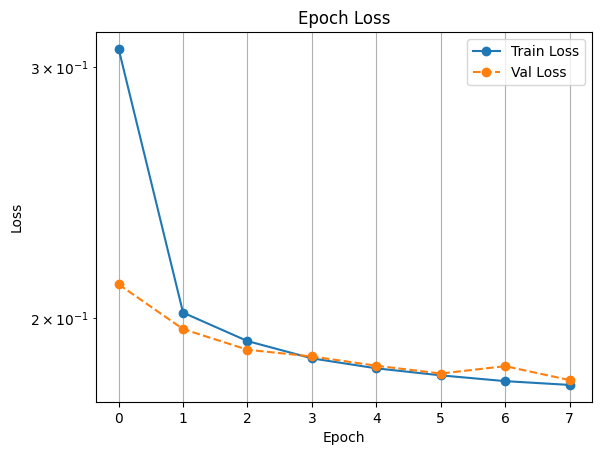

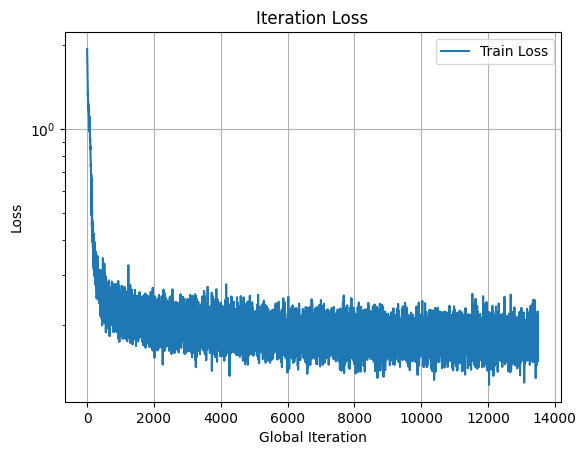

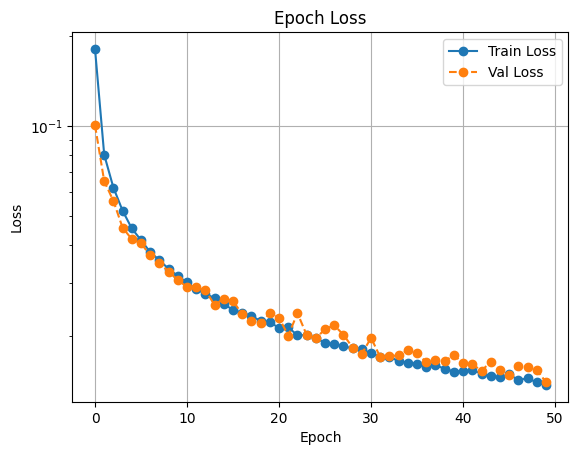

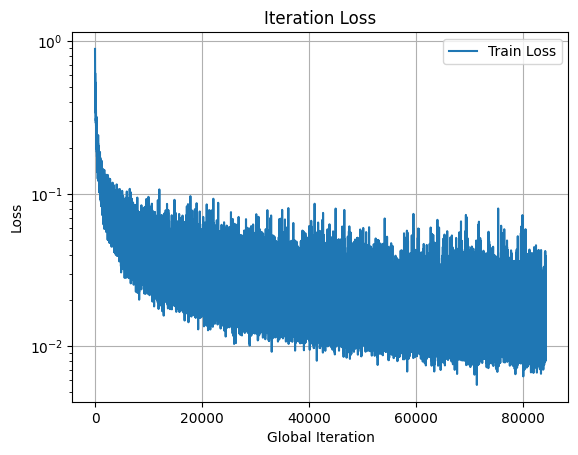

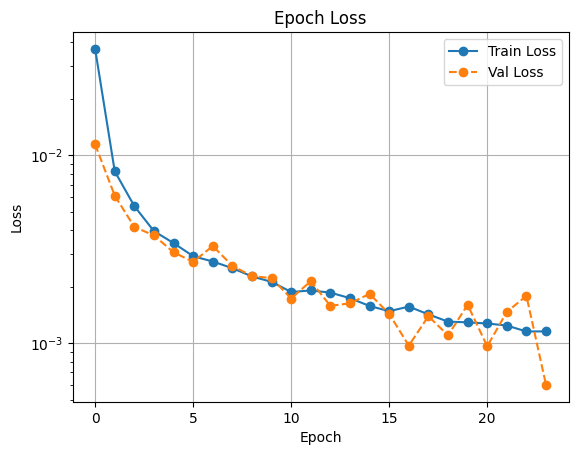

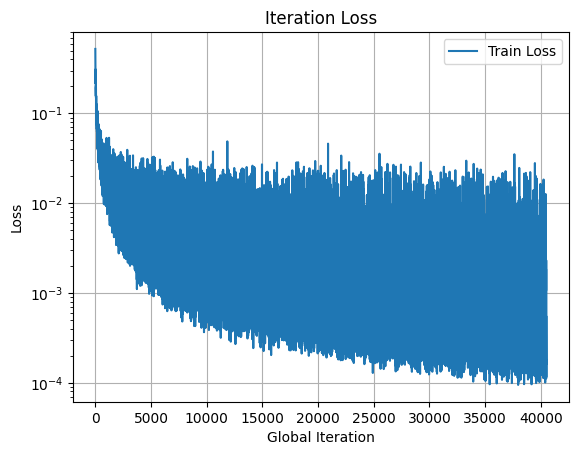

In [70]:
plot_history(trainer1, show_iter=True, max_iters=None, logy=True)
plot_history(trainer2, show_iter=True, max_iters=None, logy=True)
plot_history(trainer3, show_iter=True, max_iters=None, logy=True)

Saved epoch plot to training_comparison_all_cases.png


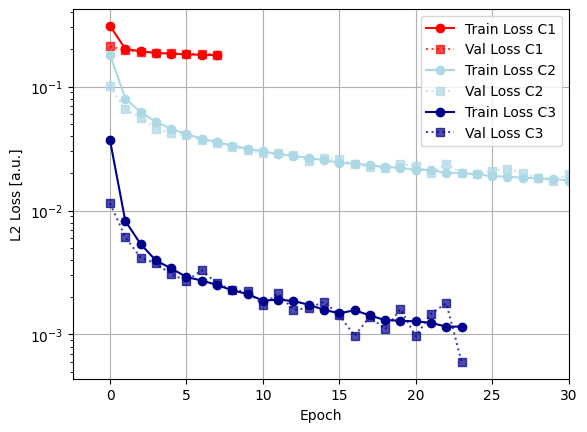

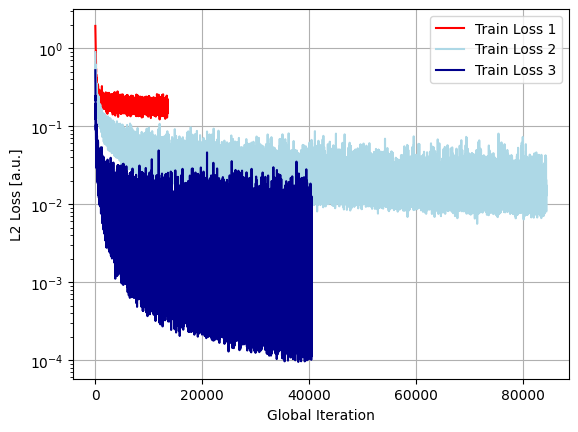

In [95]:
#plot_history(trainer_c1, show_iter=True, max_iters=None, logy=False)
trainers = [trainer1, trainer2, trainer3]
plot_histories(trainers, show_iter=True, max_iters=None, logx=False, xlim = 30,
               logy=True, save_path_epoch="training_comparison_all_cases.png")

## Generated digits with time (test set)

### Case 1 

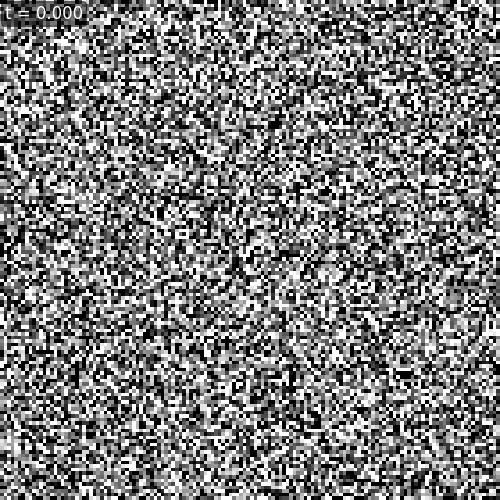

In [72]:
num_digits  = 25
x0_test = test_loader1.x0_stacked
trajs = sample_flow_x_all(trainer1.model, x=x0_test[:num_digits].to(device), steps=10, device=device)
gif_name = f"trajectory_trainedEpochs{trainer1.epoch}.gif"
gif_path = os.path.join(save_best_path1 , gif_name)
save_trajectory_gif(
    trajs,
    path=gif_path,
    fps=2)
#show_trajectory_collated(trajs, nrow=None, every=1, title=None)

Image(gif_path)  # Display the saved GIF in the notebook


### Case 2

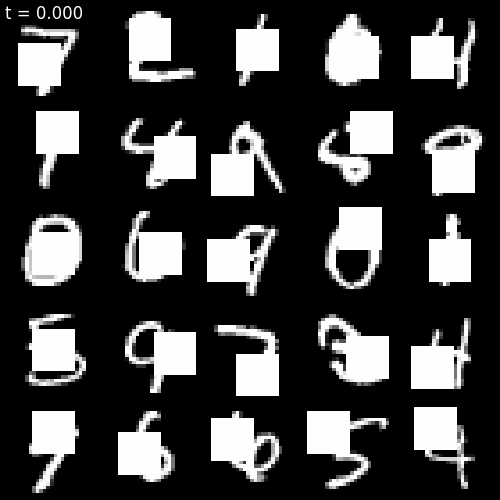

In [73]:
num_digits  = 25
x0_test = test_loader2.x0_stacked
trajs = sample_flow_x_all(trainer2.model, x=x0_test[:num_digits].to(device), steps=10, device=device)
gif_name = f"trajectory_trainedEpochs{trainer2.epoch}.gif"
gif_path = os.path.join(save_best_path2 , gif_name)
save_trajectory_gif(
    trajs,
    path=gif_path,
    fps=2)
#show_trajectory_collated(trajs, nrow=None, every=1, title=None)

Image(gif_path)  # Display the saved GIF in the notebook

### Case 3 

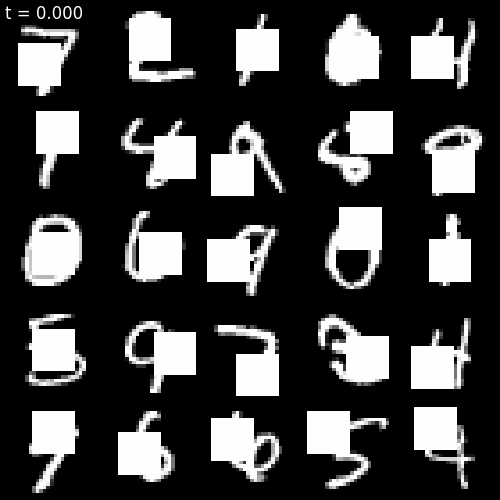

In [74]:
num_digits  = 25
x0_test = test_loader3.x0_stacked
trajs = sample_flow_x_all(trainer3.model, x=x0_test[:num_digits].to(device), steps=10, device=device)
gif_name = f"trajectory_trainedEpochs{trainer3.epoch}.gif"
gif_path = os.path.join(save_best_path3 , gif_name)
save_trajectory_gif(
    trajs,
    path=gif_path,
    fps=2)
#show_trajectory_collated(trajs, nrow=None, every=1, title=None)

Image(gif_path)  # Display the saved GIF in the notebook